# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


### Change directory

In [0]:
DATASET_FOLDER = '/content/drive/My Drive/AIML/Internal Lab/14Jul2019/'

In [0]:
TRAIN_CSV_ORIG = DATASET_FOLDER+"train_labels.csv"

In [10]:
TRAIN_CSV_ORIG

'/content/drive/My Drive/AIML/Internal Lab/14Jul2019/train_labels.csv'

In [0]:
images_path = DATASET_FOLDER + "images_racoon/"

In [7]:
images_path

'/content/drive/My Drive/AIML/Internal Lab/14Jul2019/images_racoon/'

### Load the training data from train.csv file

### Skip the header

In [0]:
with open(TRAIN_CSV_ORIG,'r') as f:
    with open(DATASET_FOLDER+"updated_train_labels.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
            
TRAIN_CSV = "updated_train_labels.csv"

### Print the shape of the train dataset

In [12]:
data = np.genfromtxt("updated_train_labels.csv", delimiter=',', names=True)
table = data.view(np.float64).reshape(len(data), -1)
table.shape

(172, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
               
        for i, r in enumerate(row[1:8]): # Parse row with seven entities
            if(i != 2):
                row[i+1] = int(r)    
        
        path, image_width, image_height ,class_1, x0, y0, x1, y1 = row  
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

In [15]:
print(paths)

['raccoon-17.jpg', 'raccoon-11.jpg', 'raccoon-63.jpg', 'raccoon-63.jpg', 'raccoon-60.jpg', 'raccoon-69.jpg', 'raccoon-180.jpg', 'raccoon-200.jpg', 'raccoon-141.jpg', 'raccoon-19.jpg', 'raccoon-84.jpg', 'raccoon-124.jpg', 'raccoon-182.jpg', 'raccoon-111.jpg', 'raccoon-91.jpg', 'raccoon-79.jpg', 'raccoon-93.jpg', 'raccoon-20.jpg', 'raccoon-42.jpg', 'raccoon-139.jpg', 'raccoon-58.jpg', 'raccoon-71.jpg', 'raccoon-183.jpg', 'raccoon-1.jpg', 'raccoon-169.jpg', 'raccoon-82.jpg', 'raccoon-4.jpg', 'raccoon-101.jpg', 'raccoon-10.jpg', 'raccoon-166.jpg', 'raccoon-184.jpg', 'raccoon-38.jpg', 'raccoon-120.jpg', 'raccoon-142.jpg', 'raccoon-149.jpg', 'raccoon-51.jpg', 'raccoon-43.jpg', 'raccoon-123.jpg', 'raccoon-66.jpg', 'raccoon-9.jpg', 'raccoon-178.jpg', 'raccoon-47.jpg', 'raccoon-167.jpg', 'raccoon-54.jpg', 'raccoon-77.jpg', 'raccoon-155.jpg', 'raccoon-89.jpg', 'raccoon-153.jpg', 'raccoon-179.jpg', 'raccoon-115.jpg', 'raccoon-64.jpg', 'raccoon-56.jpg', 'raccoon-44.jpg', 'raccoon-39.jpg', 'raccoon

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
# import os
# CUR_DIR = os.getcwd()

In [0]:
# CUR_DIR

'C:\\Users\\msrikanta\\OneDrive - VMware, Inc\\MDS\\Trainings\\Great lakes\\Internal Lab\\14Jul2019'

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
#     f1 = CUR_DIR + "/images_racoon/images/" + f
    f1 = images_path + f
    img = Image.open(f1) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [17]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

W0714 11:15:30.367108 140150864217984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 11:15:30.430726 140150864217984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 11:15:30.444270 140150864217984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 11:15:30.488487 140150864217984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0714 11:15:30.489557 1401508642

17227776/17225924 [==============================] - 3s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [19]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,coords,
            epochs=30,batch_size = 32,
            verbose=1)

W0714 11:16:40.150155 140150864217984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 11:16:40.191658 140150864217984 deprecation.py:323] From <ipython-input-18-a811784d62ce>:25: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

Epoch 1/30
173/173 [==============================] - 4s 22ms/step - loss: 2770.7603 - IoU: 0.0808
Epoch 2/30
173/173 [==============================] - 0s 1ms/step - loss: 634.0318 - IoU: 0.4380
Epoch 3/30
173/173 [==============================] - 0s 1ms/step - loss: 681.3706 - IoU: 0.5320
Epoch 4/30
173/173 [==============================] - 0s 1ms/step - loss: 578.9386 - IoU: 0.5315
Epoch 5/30
173/173 [==============================] - 0s 1ms/step - loss: 339.0066 - IoU: 0.5879
Epoch 6/30
173/173 [==============================] - 0s 1ms/step - loss: 277.9698 - IoU: 0.5766
Epoch 7/30
173/173 [==============================] - 0s 1ms/step - loss: 241.6390 - IoU: 0.6073
Epoch 8/30
173/173 [==============================] - 0s 1ms/step - loss: 187.3267 - IoU: 0.6693
Epoch 9/30
173/173 [==============================] - 0s 1ms/step - loss: 166.7975 - IoU: 0.7013
Epoch 10/30
173/173 [==============================] - 0s 1ms/step - loss: 144.0895 - IoU: 0.7189
Epoch 11/30
173/173 [======

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = images_path+'raccoon-31.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

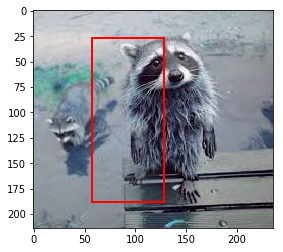

In [24]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
#Already done

#### Change your present working directory

### Load your data file

In [0]:
import pandas as pd

In [26]:
df = pd.read_csv('/content/drive/My Drive/AIML/Internal Lab/14Jul2019/daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())


            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


#### Plot data

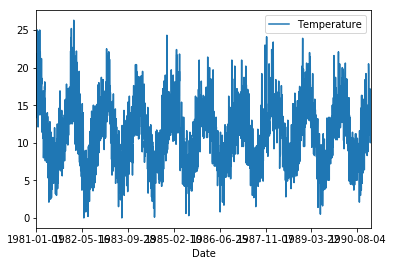

In [27]:
df.plot()

#### Descibe your dataframe

In [28]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [29]:
df.isnull().sum()

Temperature    0
dtype: int64

No null values

#### Drop null values

In [0]:
#No Null values so nothing to drop
#df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76c68434e0>]],
      dtype=object)

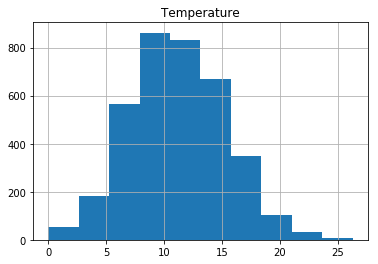

In [32]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [33]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [34]:
df.columns

Index(['Temperature'], dtype='object')

In [0]:
df['Temperature'] = df['Temperature']/100 #normalize the data

In [36]:
df.dtypes

Temperature    float64
dtype: object

In [0]:
dataset = df.astype('float32')

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [39]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [40]:
print(scaled[:10])

[[0.78707222]
 [0.68060835]
 [0.71482884]
 [0.55513305]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159691]
 [0.82889728]
 [0.76045625]]


### Split data into Training and Testing

In [41]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [42]:
print(train_size)

2555


In [43]:
print(test_size)

3650


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [45]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707222]
Y 1
0.680608354893745
1
X 1 to 2
[0.68060835]
Y 2
0.7148288417571539
2
X 2 to 3
[0.71482884]
Y 3
0.555133047533229
3
X 3 to 4
[0.55513305]
Y 4
0.6007604577817827
4
X 4 to 5
[0.60076046]
Y 5
0.6007604577817827
5
X 5 to 6
[0.60076046]
Y 6
0.6007604577817827
6
X 6 to 7
[0.60076046]
Y 7
0.6615969103491789
7
X 7 to 8
[0.66159691]
Y 8
0.8288972823909303
8
X 8 to 9
[0.82889728]
Y 9
0.7604562520057075
9
X 9 to 10
[0.76045625]
Y 10
0.6159695567590304
10
X 10 to 11
[0.61596956]
Y 11
0.5057034050341673
11
X 11 to 12
[0.50570341]
Y 12
0.6349809446451915
12
X 12 to 13
[0.63498094]
Y 13
0.8174904723225958
13
X 13 to 14
[0.81749047]
Y 14
0.9505703008425331
14
X 14 to 15
[0.9505703]
Y 15
0.787072217709695
15
X 15 to 16
[0.78707222]
Y 16
0.7832699288007818
16
X 16 to 17
[0.78326993]
Y 17
0.9429657230247067
17
X 17 to 18
[0.94296572]
Y 18
0.6730037770759186
18
X 18 to 19
[0.67300378]
Y 19
0.5893535910550429
19
X 19 to 20
[0.58935359]
Y 20
0.6920151649620796
20
X 20 to 21
[

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [46]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Also Train the model

In [48]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU, Dense
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 16s - loss: 0.0273
Epoch 2/20
 - 15s - loss: 0.0169
Epoch 3/20
 - 15s - loss: 0.0136
Epoch 4/20
 - 15s - loss: 0.0118
Epoch 5/20
 - 15s - loss: 0.0108
Epoch 6/20
 - 15s - loss: 0.0103
Epoch 7/20
 - 15s - loss: 0.0103
Epoch 8/20
 - 15s - loss: 0.0103
Epoch 9/20
 - 15s - loss: 0.0102
Epoch 10/20
 - 15s - loss: 0.0102
Epoch 11/20
 - 15s - loss: 0.0103
Epoch 12/20
 - 15s - loss: 0.0103
Epoch 13/20
 - 15s - loss: 0.0102
Epoch 14/20
 - 15s - loss: 0.0102
Epoch 15/20
 - 15s - loss: 0.0102
Epoch 16/20
 - 15s - loss: 0.0103
Epoch 17/20
 - 15s - loss: 0.0102
Epoch 18/20
 - 15s - loss: 0.0102
Epoch 19/20
 - 15s - loss: 0.0103
Epoch 20/20
 - 15s - loss: 0.0103


### Summarize your model

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model - done above

## Make Predictions and Evaluate your model

In [50]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.02 RMSE


## Plot the results

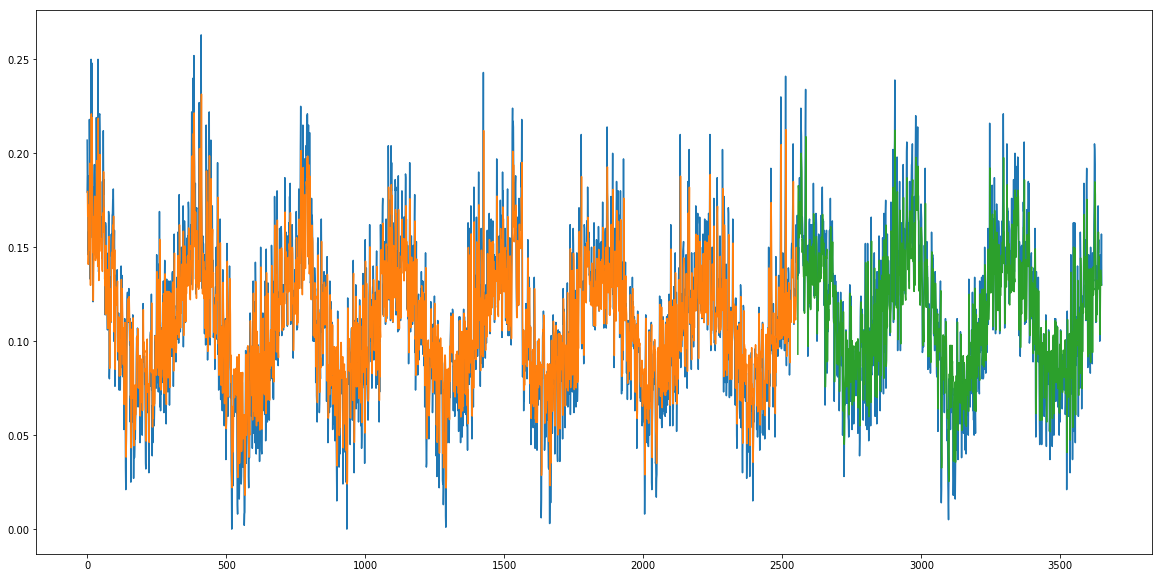

In [51]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()